<h1><b><span style="color: #e56b6f; font-size: 28px">TABLE OF CONTENTS</span></b></h1>

* [Overview](#0)
* [1. Exploratory Data Analysis](#1)
    * [1.1 Importing Libraries](#1_1)
    * [1.2 Loading Dataset](#1_2)
    * [1.3 Data Visualization](#1_3)
    * [1.4 TEXT PREPROCESSING](#1_4)
    * [1.5 Lemmatize the Words](#1_5)
    * [1.6 Words Clouds](#1_6)
* [2. Text Preprocessing](#2)
* [3. Data Preparation for BERT](#3)
    * [3.1 Setting up our Data](#3_1)
        * [3.1.1 Train-Val-Test Split](#3_1_1)
        * [3.1.2 Selecting Max length](#3_1_2)
    * [3.2 Setting up our Dataloaders](#3_2)
        * [3.2.1 Defining Parameters](#3_2_1)
        * [3.2.2 Creating a PyTorch Dataset](#3_2_2)
        * [3.2.3 Creating the Dataloaders](#3_2_3)
* [4. Building Model with BERT](#4)
    * [4.1 Defining the Model Architecture](#4_1)
    * [4.2 Training](#4_2)
        * [4.2.1 Training Process per Epoch](#4_2_1)
        * [4.2.2 Model Evaluation Function](#4_2_2)
        * [4.2.3 Training Loop](#4_2_3)
        * [4.2.4 Setting Up Optimiser and Scheduler](#4_2_4)
        * [4.2.4 Plotting the Training and Val Loss](#4_2_5)

    * [4.3 Prediction](#4_3)
        * [4.3.1 Evaluting Model on Test](#4_3_1)

<a id="0"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">OVERVIEW</span></b></h1>

In this notebook, we are going to do semantic analysis on hotel reviews. We will 2 different approaches:
1. With machine learning models using sklearn
2. With deep neural network 

There are also some text preprocessing before we train our model to make sure that our data is clean. At the end of this notebook, we will try to predict the sentiment of our own review

**So, let's dive into the code!**

<a id="1"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">1. Exploratory Data Analysis</span></b></h1>

<a id="1_1"></a>
<h2><b><span style="color: #e56b6f; font-size: 20px">1.1 IMPORTING LIBRARIES</span></b></h2>

In [1]:
# Load required libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud # type: ignore
import string
%matplotlib inline

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#For Bert Model
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (BertModel,BertTokenizer,AdamW,get_linear_schedule_with_warmup,)


<a id="1_2"></a>
<h1><b><span style="color: #e56b6f; font-size: 20px">1.2 LOADING DATASET</span></b></h1>

In [2]:
data = pd.read_csv('data/Hotel_Reviews.csv')
print(f"Dataset shape: {data.shape}")

Dataset shape: (515738, 17)


In [3]:
print(f"Feature name : {data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

<b><span style="font-size: 15px"> To focus on the columns required for sentiment analysis, you'll typically need the text data for sentiment analysis and a label or score to train the model. Let's assume your dataset has columns like Hotel_Name, review (the text data) and Reviewer_Score (the sentiment label).</span></b>

In [4]:
# append the positive and negative text reviews
data["Review"] = data["Negative_Review"] + data["Positive_Review"]
# create the label
data["Rating"] = data["Reviewer_Score"]#.apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
df = data[["Hotel_Name","Review", "Rating"]]
df.head()

,Hotel_Name,Review,Rating
0,Hotel Arena,I am so angry that i made this post available...,2.9
1,Hotel Arena,No Negative No real complaints the hotel was g...,7.5
2,Hotel Arena,Rooms are nice but for elderly a bit difficul...,7.1
3,Hotel Arena,My room was dirty and I was afraid to walk ba...,3.8
4,Hotel Arena,You When I booked with your company on line y...,6.7


Sample data

In [5]:
df = df.sample(frac=0.1,replace=False,random_state=42)

In [6]:
#data.head()

<a id="1_3"></a>
<h1><b><span style="color: #e56b6f; font-size: 20px">1.3 DATA VISUALIZATION</span></b></h1>

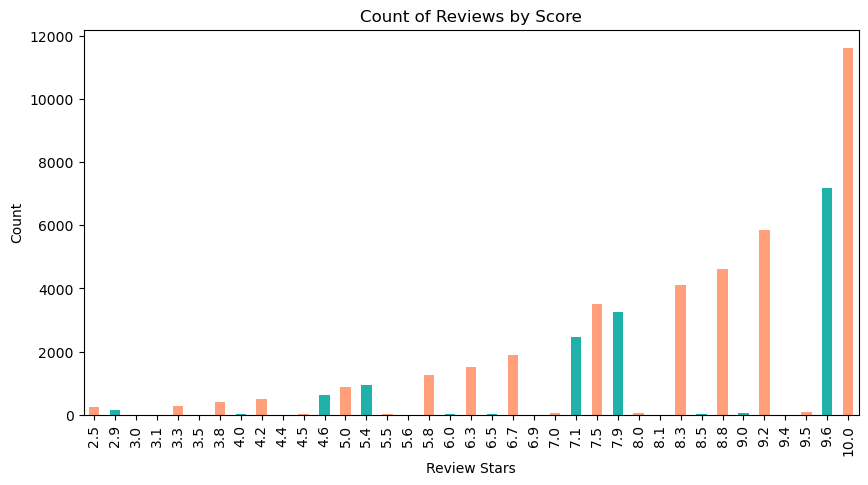

In [7]:
ax = df['Rating'].value_counts().sort_index(ascending=True) \
    .plot(kind='bar',title="Count of Reviews by Score", figsize=(10,5),color=['#FFA07A', '#20B2AA'])
ax.set_xlabel('Review Stars')
ax.set_ylabel('Count')
plt.show()

In [8]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)

df['Rating'] = df['Rating'].apply(lambda x : 1 if x>5 else 0)
df.head()

,Hotel_Name,Review,Rating,Length
488440,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,1,599
274649,Urban Lodge Hotel,No tissue paper box was present at the roomNo...,1,55
374688,Alexandra Barcelona A DoubleTree by Hilton,Pillows Nice welcoming and service,1,36
404352,Hotel Principe Di Savoia,No Negative Everything including the nice upgr...,1,166
451596,Hotel Esther a,No Negative Lovely hotel v welcoming staff,1,43


In [9]:
#Check for null values
df.isnull().sum()

Hotel_Name    0
Review        0
Rating        0
Length        0
dtype: int64

<a id="1_4"></a>
<h1><b><span style="color: #e56b6f; font-size: 20px">1.4 TEXT PREPROCESSING</span></b></h1>

In [10]:
df.head()

,Hotel_Name,Review,Rating,Length
488440,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,1,599
274649,Urban Lodge Hotel,No tissue paper box was present at the roomNo...,1,55
374688,Alexandra Barcelona A DoubleTree by Hilton,Pillows Nice welcoming and service,1,36
404352,Hotel Principe Di Savoia,No Negative Everything including the nice upgr...,1,166
451596,Hotel Esther a,No Negative Lovely hotel v welcoming staff,1,43


In [11]:
# Total word in dataset before cleaning
length = df['Length'].sum()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Stemming vs Lemmatization</b></h1>

In [12]:
print('Original:')
rows = 0
print(df['Review'].iloc[rows])
print()

sentence = []
for word in df['Review'].iloc[rows].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'].iloc[rows].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
 Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices  Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again 

Stemming:
would have appreci a shop in the hotel that sold drink water etc but not necess would recommend if like us you arriv late at night to bring drink from plane airport as there s no shop nearbi there is a minibar though if you want to pay those price hotel was great clean friend staff free breakfast everi morn with good select good wifi connect nice size room with bath fridg in r

There are some difference among those 3 sentences, for instance:
* Original -> sold, drinking
* Stemming -> sold, drink
* Lemmatization -> sell, drink

This time, we will use Lemmatization in order to get the base form of the word

In [13]:
def cleaning(text):
    # Replace specific phrases
    text = text.replace("No Negative", "").replace("No Positive", "")

    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    clean_text = [lemmatizer.lemmatize(word, 'v') for word in clean_text]

    return ' '.join(clean_text)

In [14]:
df['Review'] = df['Review'].apply(cleaning)
df

,Hotel_Name,Review,Rating,Length
488440,Hotel Da Vinci,would appreciate shop hotel sell drink water e...,1,599
274649,Urban Lodge Hotel,tissue paper box present room,1,55
374688,Alexandra Barcelona A DoubleTree by Hilton,pillow nice welcome service,1,36
404352,Hotel Principe Di Savoia,everything include nice upgrade hotel revamp s...,1,166
451596,Hotel Esther a,lovely hotel v welcome staff,1,43
...,...,...,...,...
274862,Urban Lodge Hotel,bathroom water easy make bathroom wet bath wal...,1,142
9732,Grand Royale London Hyde Park,room small chair tatty room,0,52
424201,NH Collection Barcelona Gran Hotel Calder n,expensive rat mini bar price roof top pool vie...,1,80
72380,Park Avenue Baker Street,loud ac machine right outside window affect sl...,1,176


In [15]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 9683221
Total text length after cleaning: 6217646


 <a id="1_6"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">1.6 Word Clouds</span></b></h3>

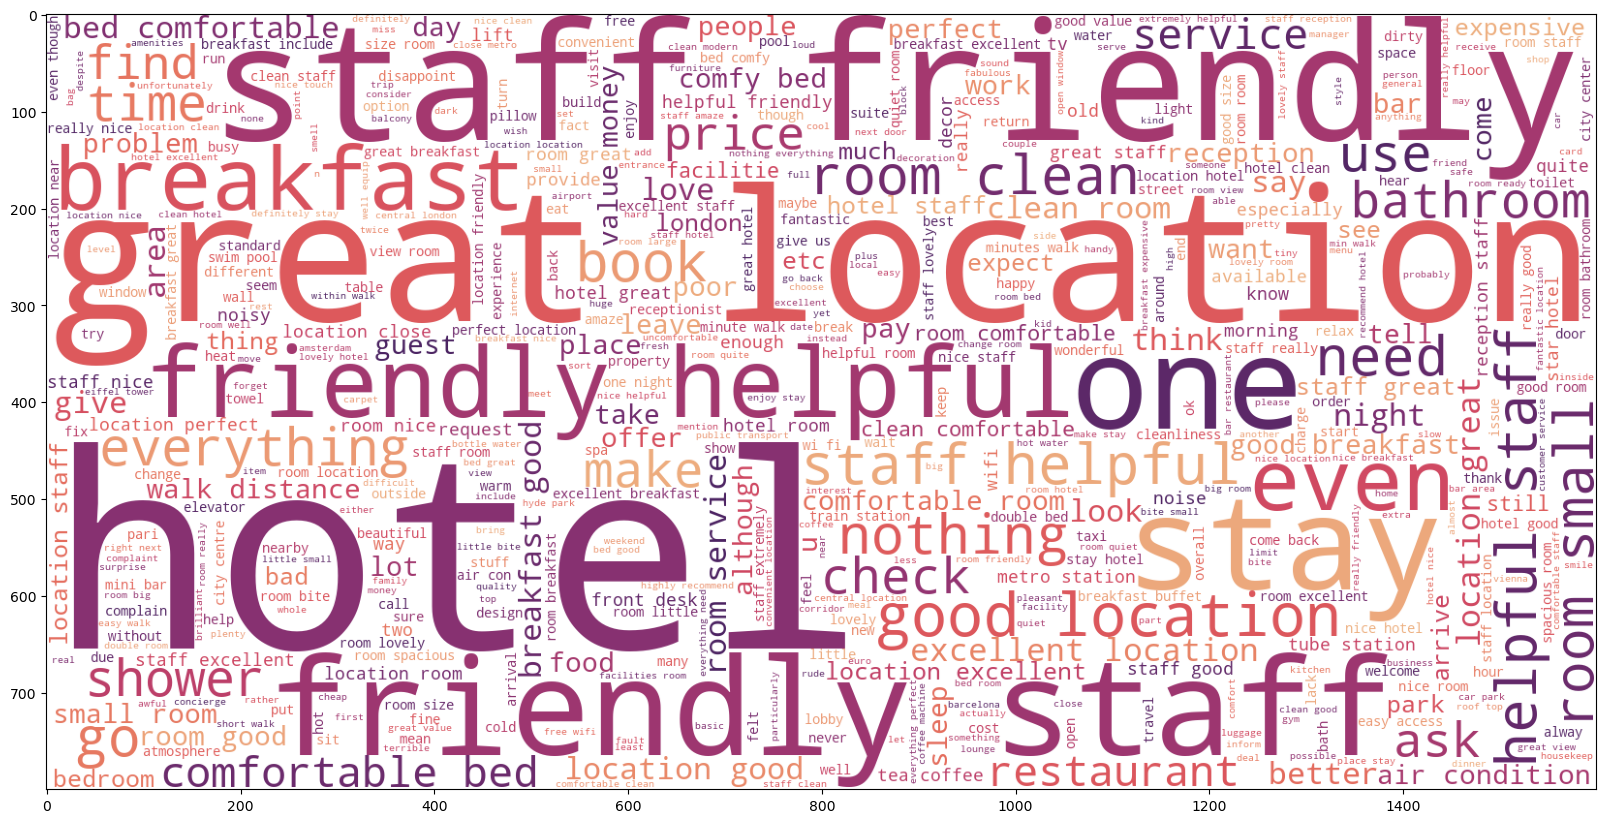

In [16]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['Review']))

plt.imshow(wc)

<a id="3"></a>
<h3><b><span style="color: #e56b6f; font-size: 28px">3. Data Preparation for BERT</span></b></h3>



There are three things we need to do to convert our data into a form amenable to BERT. These are:

    i) Pad all sequences to a constant length

    ii) Create an attention mask

    iii) Add special tokens: [SEP] which indicates the end of a sentence, and [CLS] which indicates that the task is classification

Let's use the cased version of BERT.


In [17]:
bert_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

<a id="3_1"></a>
<h3><b><span style="color: #e56b6f; font-size: 23px">3.1 Setting up our Data</span></b></h3>

We set up our training, validation, and test data and also decide the maximum sequence length to specify for the BERT model.

<a id="3_1_1"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">3.1.1 Train-Val-Test Split</span></b></h3>

We split our data into training, validation, and test sets using a 7:2:1 ratio.

In [18]:
dev, test = train_test_split(df, test_size=0.1, random_state = 100)  # splitting into dev and test sets
train, val = train_test_split(dev, test_size=0.222222, random_state = 100) # splitting dev into train and validation sets

In [19]:
# reset the indices
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

<a id="3_1_2"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">3.1.2 Selecting Max length</span></b></h3>

We need to select the fixed maximum length to which all sequences will be padded or truncated to.

Text(0.5, 1.0, 'Distribution of Tokenized Review Lengths')

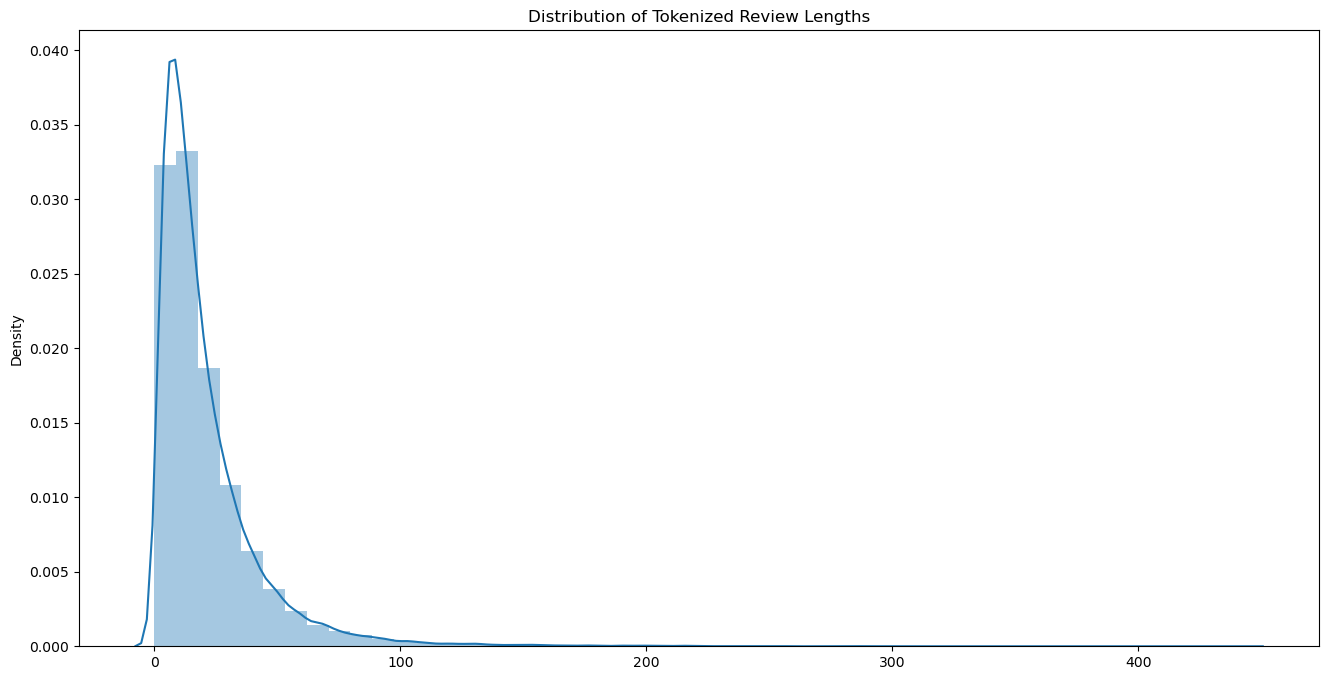

In [74]:
all_tokens = [tokenizer.tokenize(x) for x in df.Review]
plt.figure(figsize = (16,8))
sns.distplot([len(x) for x in all_tokens])
plt.title("Distribution of Tokenized Review Lengths")


<b>Looks like almost all reviews contain 150 or fewer tokens, let's calculate the exact proportion: </b>

In [21]:
print("Proportion of tokenized reviews with length <= 150: ")
len([x for x in all_tokens if len(x)<=150])/len([x for x in all_tokens])

Proportion of tokenized reviews with length <= 150: 


That is a very large proportion so we use 150 as our max sequence length in our BERT model.

<a id="3_2"></a>
<h3><b><span style="color: #e56b6f; font-size: 23px">3.2 Setting up our Dataloaders</span></b></h3>


<a id="3_2_1"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">3.2.1 Defining Parameters</span></b></h3>


In [22]:
# Define parameters
max_length = 150
batch_size = 32
n_epochs = 5
learning_rate = 2e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<a id="3_2_2"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">3.2.2 Creating a PyTorch Dataset</span></b></h3>


In [23]:
class ReviewDataset(Dataset):
    """
    a pytorch dataset object for our reviews
    """

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )
        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            #"targets": torch.tensor(target, dtype=torch.long),
            "targets": torch.tensor(target,dtype=torch.float)
        }

<a id="3_2_3"></a>
<h2><b><span style="color: #e56b6f; font-size: 20px">3.2.3 Creating the Dataloaders</span></b></h2>

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        reviews=df.Review.to_numpy(),
        targets=df.Rating.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        #num_workers=3,
        shuffle=True
    )

<a id="4"></a>
<h2><b><span style="color: #e56b6f; font-size: 28px">4. Building Model with BERT</span></b></h2>

<a id="4_1"></a>
<h3><b><span style="color: #e56b6f; font-size: 23px">4.1 Defining the Model Architecture</span></b></h3>

Downloading the Bert Model

In [25]:
bert_model = BertModel.from_pretrained(bert_model_name)

Specifying our sentiment classifier architecture:

In [26]:
class BinarySentimentClassifier(nn.Module):
    def __init__(self):
        super(BinarySentimentClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

<a id="6_2"></a>
<h3><b><span style="color: #e56b6f; font-size: 23px">4.2 Training</span></b></h3>

In this section, we set the requisite functionalities for carrying out model training and evaluation.

In [27]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, accuracy_score

<a id="4_2_1"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">4.2.1 Training Process per Epoch</span></b></h3>


In [28]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, epo):
    
    model = model.train()
    total_loss = 0
    
    for i, d in enumerate(data_loader):
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        label = d["targets"].to(device)
        
        score = model(input_ids=input_ids, attention_mask=attention_mask)
        m = torch.nn.Sigmoid()
        n = torch.squeeze(m(score), 1)
        loss = loss_fn(n, label)
        total_loss+=loss.item()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        if i%100 ==0:
            print("Training at epoch {} iteration {} with loss {}".format(epo+1,i+1,loss))
        
    return total_loss

<a id="4_2_2"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">4.2.2 Model Evaluation Function</span></b></h3>


In [29]:
def test_(model, data_loader, loss_fn, device, l):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0
    preds, labels = [], []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            label = d["targets"].to(device)
           
            score = model(input_ids=input_ids, attention_mask=attention_mask)
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score), 1)
            loss = loss_fn(n, label)
            total_loss+=loss.item()
            
            n = n.detach().cpu().numpy()
            label = label.to('cpu').numpy()
            n=n.flatten().tolist()
            label=label.flatten().tolist()
            
            preds+=n
            labels+=label
            
            #loss = loss_fn(outputs, targets)
            #correct_predictions += torch.sum(preds == targets)
            #losses.append(loss.item())
            
        auroc = roc_auc_score(labels, preds)
        auprc = average_precision_score(labels, preds)
        accuracy = accuracy_score(labels, np.round(preds))
        f1 = f1_score(labels, np.round(preds))
        avg_BCEloss = total_loss/l
        
            
    return (auroc, auprc, accuracy, f1, avg_BCEloss)

<a id="4_2_3"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">4.2.3 Training Loop</span></b></h3>


In [30]:
def train_(n_epochs, model, train_gen, val_gen, optimizer, scheduler, loss_fn, device):
    history = {'train_loss': [], 'val_auroc': [], 'val_auprc': [], 'val_acc': [], 'val_f1': [], 'val_loss': []}
    max_auroc = 0
    
    for epoch in range(n_epochs):
        print("Starting epoch {}".format(epoch+1))
        train_loss = train_epoch(model, train_gen, loss_fn, optimizer, device, scheduler, epoch)
        history['train_loss'].append(train_loss)
        
        print("Going for Validation")
        val_metrics = test_(model, val_gen, loss_fn, device, len(val_gen))
        a, b, c, d, e = val_metrics
        history['val_auroc'].append(a)
        history['val_auprc'].append(b)
        history['val_acc'].append(c)
        history['val_f1'].append(d)
        history['val_loss'].append(e)

        if a > max_auroc:
            torch.save(model.state_dict(), "best_model.pt")
            max_auroc = a
            
        print(f"Validation loss after epoch {epoch+1}: {e}")
    
    return history

<a id="4_2_4"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">4.2.4 Setting Up Optimiser and Scheduler</span></b></h3>


In [68]:
train_gen = create_data_loader(train[:30000],tokenizer, max_length, batch_size)
val_gen = create_data_loader(val[:10000],tokenizer, max_length, batch_size)
test_gen = create_data_loader(test,tokenizer, max_length, batch_size)

In [32]:
model = BinarySentimentClassifier()
model.to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
total_steps = len(train_gen) * n_epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.BCELoss().to(device)

In [34]:
# Train the model
history = train_(n_epochs, model, train_gen, val_gen, optimizer, scheduler, loss_fn, device)

Starting epoch 1
Training at epoch 1 iteration 1 with loss 0.5320929288864136
Training at epoch 1 iteration 101 with loss 0.10450438410043716
Training at epoch 1 iteration 201 with loss 0.3324795663356781
Training at epoch 1 iteration 301 with loss 0.41089481115341187
Training at epoch 1 iteration 401 with loss 0.4097243845462799
Training at epoch 1 iteration 501 with loss 0.2545010447502136
Training at epoch 1 iteration 601 with loss 0.14845088124275208
Training at epoch 1 iteration 701 with loss 0.057875510305166245
Training at epoch 1 iteration 801 with loss 0.2263011932373047
Training at epoch 1 iteration 901 with loss 0.2754179537296295
Going for Validation
Validation loss after epoch 1: 0.18561786503647082
Starting epoch 2
Training at epoch 2 iteration 1 with loss 0.18436385691165924
Training at epoch 2 iteration 101 with loss 0.2517470717430115
Training at epoch 2 iteration 201 with loss 0.10334127396345139
Training at epoch 2 iteration 301 with loss 0.14360806345939636
Training

<a id="4_2_5"></a>
<h3><b><span style="color: #e56b6f; font-size: 20px">4.2.5 Plotting the Training and Val Loss</span></b></h3>

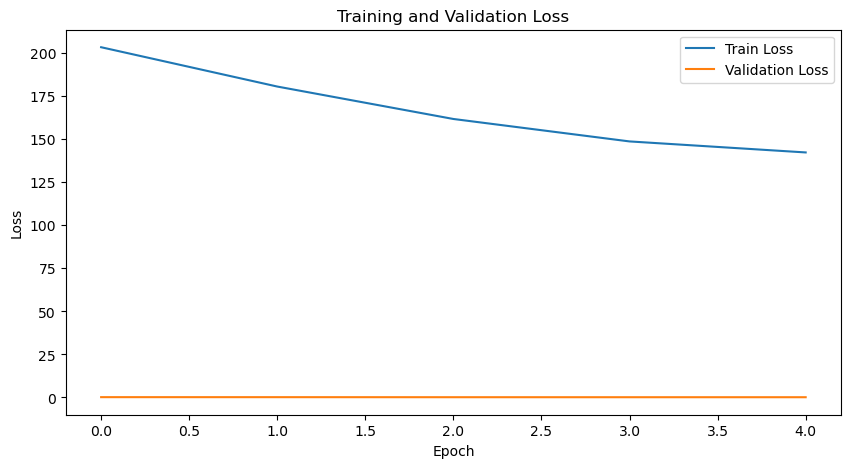

In [35]:
# Plot the metrics
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


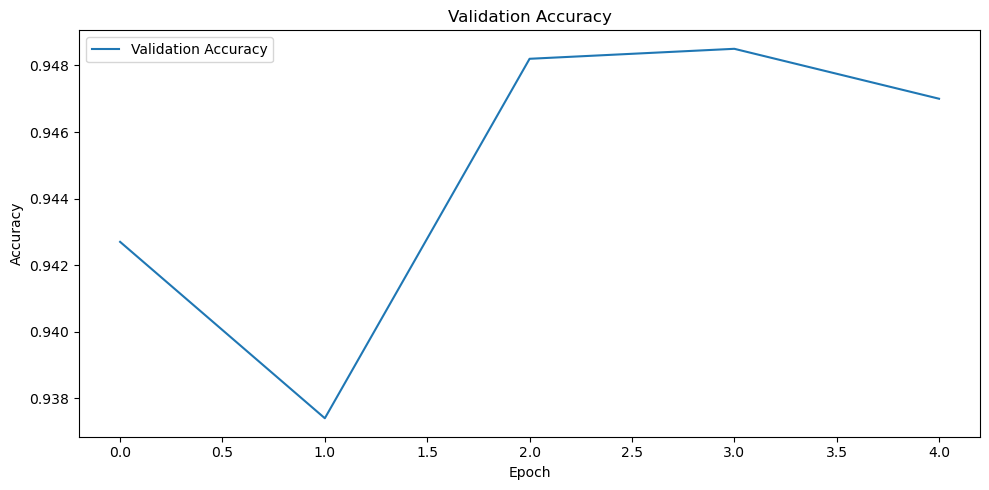

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<a id="4_3"></a>
<h3><b><span style="color: #e56b6f; font-size: 28px">4.3 Prediction</span></b></h3>

<a id="4_3_1"></a>
<h3><b><span style="color: #e56b6f; font-size: 23px">4.3.1 Evaluting Model on Test</span></b></h3>

In [69]:
test_metrics = test_(model, test_gen, loss_fn, device, len(test_gen))
test_metrics

(0.8945374333266899,
 0.9917221654307533,
 0.9426134160527336,
 0.9699736254818422,
 0.15757329453840668)

In [70]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            m = torch.nn.Sigmoid()
            preds = torch.squeeze(m(outputs), 1)
            preds = preds.round().cpu().numpy()
            
            predictions.extend(preds.tolist())
            actual_labels.extend(labels.cpu().numpy().tolist())
    
    accuracy = accuracy_score(actual_labels, predictions)
    report = classification_report(actual_labels, predictions, digits=4)
    cm = confusion_matrix(actual_labels, predictions)

    
    return accuracy, report, cm

Test Accuracy: 0.9426
Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.5294    0.2656    0.3537       305
         1.0     0.9552    0.9852    0.9700      4853

    accuracy                         0.9426      5158
   macro avg     0.7423    0.6254    0.6618      5158
weighted avg     0.9301    0.9426    0.9335      5158



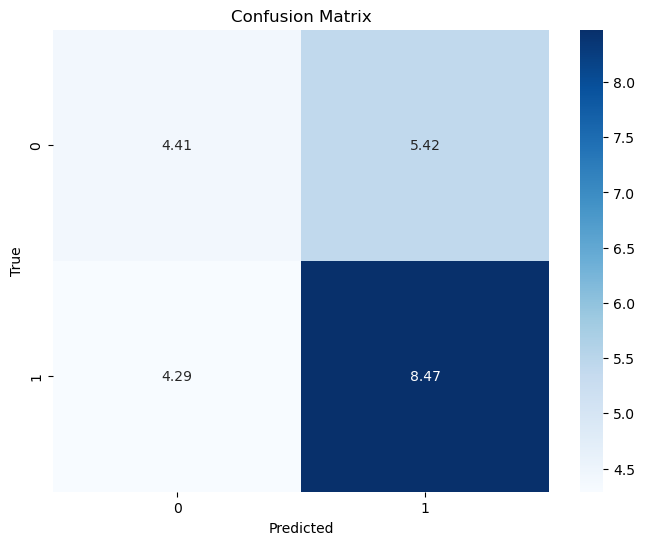

[[  81  224]
 [  72 4781]]


In [71]:
# Assume test_gen is your test DataLoader
test_accuracy, test_report, cm  = evaluate(model, test_gen, device)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(test_report)
# Use a heatmap with a logarithmic scale to better visualize the data
plt.figure(figsize=(8, 6))
sns.heatmap(np.log1p(cm), annot=True, fmt=".2f", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("ConfusionMatrixUsingTransformer.pdf", format="pdf",bbox_inches="tight")
plt.show()
print(cm)


In [72]:
def predict_rating(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        sigmoid = torch.nn.Sigmoid()
        preds = sigmoid(outputs)
        preds = preds.squeeze().cpu().item()
        sentiment = ''
        if preds >= 0.5:
            sentiment = "Positive review :)"
        else:
            sentiment = "Negative review :("

    return f"{text} ==> sentiment score: {preds:.4f} {sentiment}"

In [73]:
text1 = "The room was small and dirty"
text2 = 'The staff was friendly and we really enjoy the food at the hotel'
prediction1 = predict_rating(text1, model, tokenizer, device)
prediction2 = predict_rating(text2, model, tokenizer, device)
print(f"Prediction: {prediction1}")
print(f"Prediction: {prediction2}")

Prediction: The room was small and dirty ==> sentiment score: 0.4619 Negative review :(
Prediction: The staff was friendly and we really enjoy the food at the hotel ==> sentiment score: 0.9812 Positive review :)
